# Raman-Evs Data anlysis 



> 1 - Loading the data and pre-processing 

> 2 - RandomForest Model Training

> 3 - Knn Model Training

> 4 - XGboost Model Training

> 6 - SVM Model Traininig


























1 - Loading the data and pre-processing

In [1]:
import numpy
import pandas as pd

ftir_data =pd.read_csv('3500-1000_emsc-mean_cut_3500-2800_1800-1000.csv')
# drop the first 5 cols 
ftir_data1 = ftir_data.drop(ftir_data.columns[0:5], axis=1)
ftir_data2 = ftir_data1.drop(ftir_data1.columns[1:31], axis=1)
ftir_data3 = ftir_data2.drop(ftir_data2.columns[2:5], axis=1)
ftir_data4 = ftir_data3.drop(ftir_data3.columns[1], axis=1)


# get mean for each pid replicate 
ftir_data5 = ftir_data4.groupby('pid').mean()
ftir_data6 = ftir_data3.drop(ftir_data4.columns[1:1504], axis=1)

# merge ftir_data5 with ftir_data6 get class 
ftir_data7 = pd.merge(ftir_data5, ftir_data6, on='pid', how='inner')
# drop dublicate rows
ftir_data8 = ftir_data7.drop_duplicates()


# from pid string replace EV with '' 
ftir_data8['pid'] = ftir_data8['pid'].str.replace('EV', '')

# # save to csv
ftir_data8.to_csv('processed_ftir_data.csv', index=True)



/var/folders/h0/49pf4hv97sdg37fww258kmrc0000gq/T/ipykernel_49631/2533829359.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftir_data8['pid'] = ftir_data8['pid'].str.replace('EV', '')


In [2]:

ftir_data8['target'] = ftir_data8['pid'].apply(lambda x: 0 if 'H' in x else 1) # 0 for Healthy and 1 for GBM
ftir_data8 = ftir_data8.drop(['Class'], axis = 1)

# count the number of healthy and GBM
print(ftir_data8['target'].value_counts())

# change H38rpt to H38 in pid column
FTIR_data = ftir_data8.copy()
FTIR_data['pid'] = FTIR_data['pid'].str.replace('H38', 'H38rpt', regex=False)
# Ensure pid columns have the same data type
FTIR_data['pid'] = FTIR_data['pid'].astype(str)

target
1    51
0    48
Name: count, dtype: int64


/var/folders/h0/49pf4hv97sdg37fww258kmrc0000gq/T/ipykernel_49631/1711717508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftir_data8['target'] = ftir_data8['pid'].apply(lambda x: 0 if 'H' in x else 1) # 0 for Healthy and 1 for GBM


In [ ]:
# # Add metaData age, gender & Chara
# metaData = pd.read_excel('/Users/bh358AA/Desktop/PhD/Glioma/Final_ML_GLIOMA/Healthy_vs_GBM/MetaData.xlsx', skiprows=1)
# metaData = metaData[['Sample', 'Age', 'Gender', 'Mean', 'Median', 'Total Conc']]
# metaData.rename(columns={'Sample': 'pid'}, inplace=True)
# # drop any rows with NaN in pid
# metaData = metaData.dropna(subset=['pid'])
# metaData['pid'] = metaData['pid'].replace(' ', '', regex=True)
# # convert Gender to numeric F=0, M=1
# metaData['Gender'] = metaData['Gender'].apply(lambda x: 0 if x == 'F' else 1)
# # change H38rpt to H38 in pid column
# FTIR_data = ftir_data8.copy()
# FTIR_data['pid'] = FTIR_data['pid'].str.replace('H38', 'H38rpt', regex=False)
# # Ensure pid columns have the same data type
# FTIR_data['pid'] = FTIR_data['pid'].astype(str)
# metaData['pid'] = metaData['pid'].astype(str)
# # merge metaData with miRNA_data on index
# FTIR_metaData = pd.merge(FTIR_data, metaData, on='pid', how= 'left')
# FTIR_metaData.set_index('pid', inplace=True)

# FTIR_metaData['Age'] = FTIR_metaData['Age'].fillna(FTIR_metaData['Age'].mean()) # fill missing age with mean


# # save to csv
# FTIR_metaData.to_csv('processed_FTIR_data_meta.csv', index=True)


In [3]:
FTIR_data.set_index('pid', inplace=True)
FTIR_data = FTIR_data.reset_index(drop=True)
# 
X = FTIR_data.drop(['target',], axis = 1)
y = FTIR_data['target']

# scale X 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

1a. Validation Data processing

In [4]:
# read validation data
validation_data = pd.read_csv('FTIR preprocessed-longitudinal.csv')
# use column 'pid' and keep pid that are here 'B1', 'C1', 'D1', 'E1', 'F1'
validation_data = validation_data[validation_data['pid'].isin(['B1', 'C1', 'D1', 'E1', 'F1'])]
validation_data.set_index('pid', inplace=True)
# drop first 40 columns 
validation_data = validation_data.drop(validation_data.columns[0:39], axis=1)
# drop last 23 columns
validation_data = validation_data.drop(validation_data.columns[-23:], axis=1)
# get mean for each pid replicate 
validation_data = validation_data.groupby('pid').mean()

/var/folders/h0/49pf4hv97sdg37fww258kmrc0000gq/T/ipykernel_49631/1674200229.py:2: DtypeWarning: Columns (1556) have mixed types. Specify dtype option on import or set low_memory=False.
  validation_data = pd.read_csv('FTIR preprocessed-longitudinal.csv')


RandomForest Feature Selection Process

Optimal number of features: 217
Optimal features: ['X_3031', 'X_3030', 'X_3029', 'X_3028', 'X_3027', 'X_3026', 'X_3025', 'X_3024', 'X_3023', 'X_3022', 'X_3021', 'X_3020', 'X_3019', 'X_3018', 'X_3017', 'X_3016', 'X_3015', 'X_3014', 'X_3013', 'X_3012', 'X_3011', 'X_3010', 'X_3009', 'X_3008', 'X_3006', 'X_3005', 'X_3002', 'X_3001', 'X_3000', 'X_2999', 'X_2998', 'X_2997', 'X_2996', 'X_2994', 'X_2992', 'X_2991', 'X_2990', 'X_2988', 'X_2987', 'X_2986', 'X_2985', 'X_2984', 'X_2982', 'X_2979', 'X_2978', 'X_2975', 'X_2973', 'X_2970', 'X_2967', 'X_2964', 'X_2962', 'X_2958', 'X_2949', 'X_2947', 'X_2940', 'X_2938', 'X_2935', 'X_2922', 'X_2921', 'X_2919', 'X_2907', 'X_2905', 'X_2903', 'X_2899', 'X_2897', 'X_2893', 'X_2892', 'X_2889', 'X_2888', 'X_2887', 'X_2885', 'X_2883', 'X_2880', 'X_2879', 'X_2861', 'X_2856', 'X_2855', 'X_2832', 'X_2801', 'X_1796', 'X_1794', 'X_1791', 'X_1788', 'X_1787', 'X_1784', 'X_1775', 'X_1769', 'X_1763', 'X_1758', 'X_1755', 'X_1753', 'X_1749', 'X_1748', 'X_1746', 'X_1740',

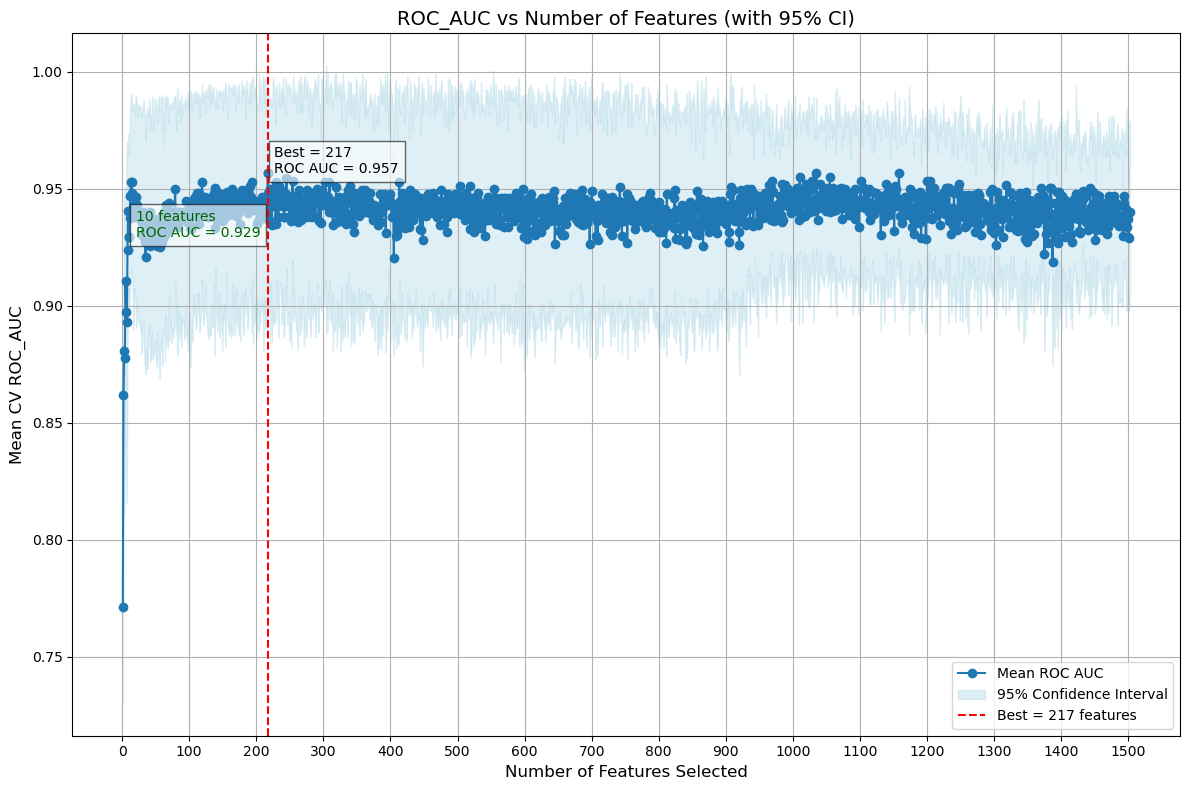

In [5]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
import numpy as np
import matplotlib.pyplot as plt 


# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize model
rf = RandomForestClassifier(n_estimators=100, random_state=42)



cv_split = StratifiedKFold(5, shuffle=True, random_state=42)

rf_rfecv = RFECV(
    estimator=rf,
    step=1,
    min_features_to_select=1,
    cv=cv_split,
    scoring="roc_auc",
    n_jobs=-1,
)

rf_rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rf_rfecv.n_features_}")
print(f"Optimal features: {list(rf_rfecv.get_feature_names_out())}")

rf_rfecv.cv_results_

def plot_features_vs_cvscore_95ci(rfecv_model, cv_folds=5):
    n_features = len(rfecv_model.cv_results_["mean_test_score"])
    mean_scores = rfecv_model.cv_results_["mean_test_score"]
    std_scores = rfecv_model.cv_results_["std_test_score"]

    # Calculate 95% CI
    ci = 1.96 * (std_scores / np.sqrt(cv_folds))

    x_range = range(1, n_features + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(x_range, mean_scores, marker='o', label='Mean ROC AUC')
    plt.fill_between(x_range,
                     mean_scores - ci,
                     mean_scores + ci,
                     color='lightblue',
                     alpha=0.4,
                     label='95% Confidence Interval')

    # Annotate best feature point
    best_idx = np.argmax(mean_scores)
    best_score = mean_scores[best_idx]
    best_n_features = best_idx + 1
    plt.axvline(best_n_features, color='red', linestyle='--', label=f'Best = {best_n_features} features')
    plt.scatter(best_n_features, best_score, color='red')
    plt.text(best_n_features + 10, best_score,
             f'Best = {best_n_features}\nROC AUC = {best_score:.3f}',
             color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    # Annotate point at 10 features 
    if n_features >= 10:
        auc_at_10 = mean_scores[9]
        plt.scatter(10, auc_at_10, color='green')
        plt.text(10 + 10, auc_at_10,
                 f'10 features\nROC AUC = {auc_at_10:.3f}',
                 color='darkgreen', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    plt.xlabel("Number of Features Selected", fontsize=12)
    plt.ylabel("Mean CV ROC_AUC", fontsize=12)
    plt.title("ROC_AUC vs Number of Features (with 95% CI)", fontsize=14)

    plt.xticks(np.arange(0, n_features + 1, step=100))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_features_vs_cvscore_95ci(rf_rfecv, cv_folds=5)

2a. RandomForest ML

Best Parameters: {'max_depth': None, 'n_estimators': 200}

Confusion matrix:


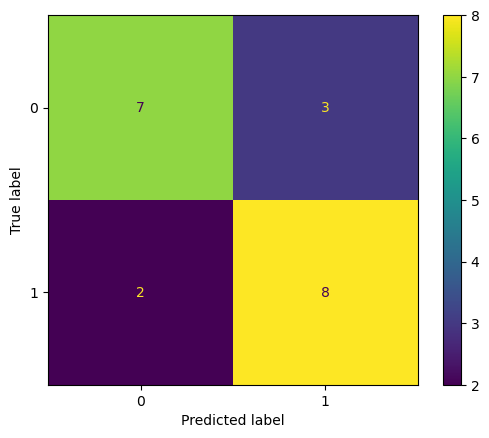

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.73      0.80      0.76        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20

CV AUC: 0.870 +/- 0.078


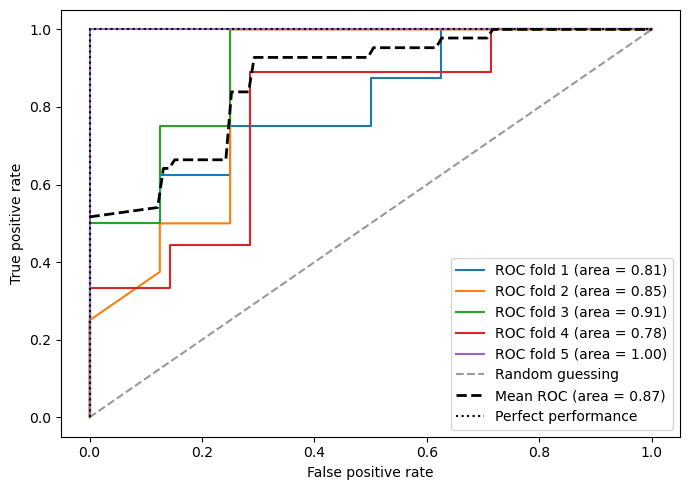

cv accuracy: 0.798 +/- 0.071
cv precision: 0.781 +/- 0.028
cv recall: 0.853 +/- 0.184
cv f1: 0.803 +/- 0.100


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.feature_selection import RFE

# Initialize result lists
AUC, AUC_sd, AC, AC_sd, Pre, Pre_sd, Re, Re_sd, f1, f1_sd, Best1, Best2 = ([] for _ in range(12))

# Reset indices of DataFrame
X_scaled, y = X_scaled.reset_index(drop=True), y.reset_index(drop=True)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


# Use only the selected features
rf_train_selected, rf_test_selected = X_train[list(rf_rfecv.get_feature_names_out())[:10]], X_test[list(rf_rfecv.get_feature_names_out())[:10]]

# Hyperparameter tuning using GridSearchCV
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [1, 2, 3, 5, None]}
gs = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy', cv=5, refit=True, n_jobs=-1)
gs.fit(rf_train_selected, y_train)

# Best hyperparameters
best_params = gs.best_params_
print(f'Best Parameters: {best_params}')

# Train final model
rf_model = RandomForestClassifier(**best_params, random_state=42)
rf_model.fit(rf_train_selected, y_train)

# Predictions on test set
test_pred = rf_model.predict(rf_test_selected)

# Confusion matrix
print("\nConfusion matrix:")
confusion_mat = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_mat, display_labels=np.unique(y))
disp.plot()
plt.show()

# Classification report
print(classification_report(y_test, test_pred, target_names=[str(label) for label in np.unique(y)]))

# ROC/AUC Calculation for Cross-Validation
cv = list(StratifiedKFold(n_splits=5).split(rf_train_selected, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
sd_list = []

for i, (train_idx, test_idx) in enumerate(cv):
    probas = rf_model.fit(rf_train_selected.iloc[train_idx], y_train.iloc[train_idx]).predict_proba(rf_train_selected.iloc[test_idx])
    fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], probas[:, 1], pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
    sd_list.append(roc_auc)

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')

mean_tpr /= len(cv)
mean_auc, mean_sd = auc(mean_fpr, mean_tpr), np.std(sd_list)

print(f'CV AUC: {mean_auc:.3f} +/- {mean_sd:.3f}')

plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

AUC.append(mean_auc)
AUC_sd.append(mean_sd)

# Nested Cross-Validation with Multiple Metrics
scores1 = cross_val_score(gs, rf_train_selected, y_train, scoring='accuracy', cv=5)
scores2 = cross_val_score(gs, rf_train_selected, y_train, scoring='precision', cv=5)
scores3 = cross_val_score(gs, rf_train_selected, y_train, scoring='recall', cv=5)
scores4 = cross_val_score(gs, rf_train_selected, y_train, scoring='f1', cv=5)

print(f'cv accuracy: {np.mean(scores1):.3f} +/- {np.std(scores1):.3f}')
print(f'cv precision: {np.mean(scores2):.3f} +/- {np.std(scores2):.3f}')
print(f'cv recall: {np.mean(scores3):.3f} +/- {np.std(scores3):.3f}')
print(f'cv f1: {np.mean(scores4):.3f} +/- {np.std(scores4):.3f}')

AC.append(np.mean(scores1))
AC_sd.append(np.std(scores1))
Pre.append(np.mean(scores2))
Pre_sd.append(np.std(scores2))
Re.append(np.mean(scores3))
Re_sd.append(np.std(scores3))
f1.append(np.mean(scores4))
f1_sd.append(np.std(scores4))
Best1.append(best_params['n_estimators'])
Best2.append(best_params['max_depth'])


3a. Knn model training using RFE (top-10 features)

Top 10 Selected Features: Index(['X_1266', 'X_1265', 'X_1264', 'X_1239', 'X_1216', 'X_1207', 'X_1135',
       'X_1134', 'X_1133', 'X_1132'],
      dtype='object')
Best n_neighbors: 9

Confusion matrix:


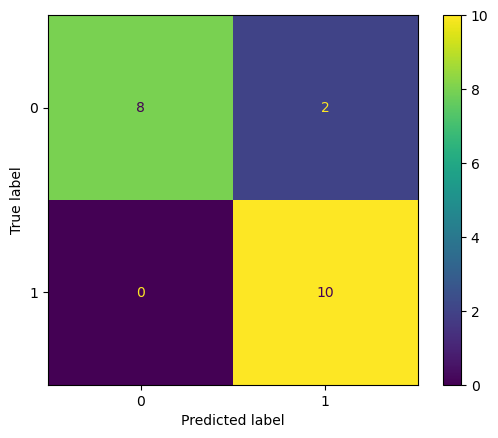

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

CV AUC: 0.959 +/- 0.043


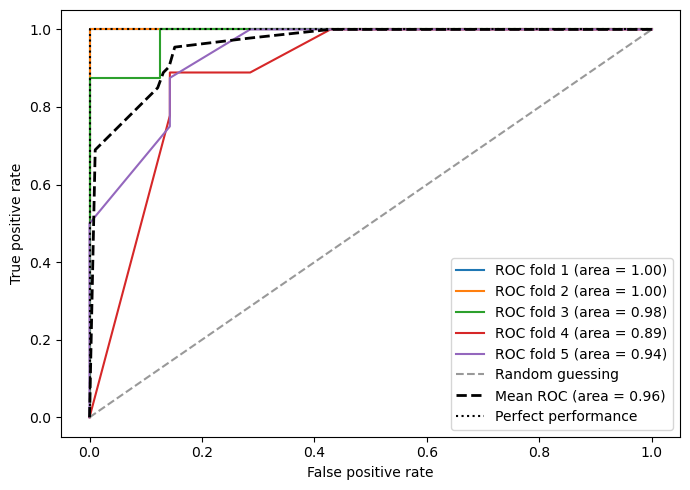

cv accuracy: 0.885 +/- 0.051
cv precision: 0.886 +/- 0.070
cv recall: 0.903 +/- 0.049
cv f1: 0.892 +/- 0.043


In [60]:
# Recressive Feature Elimination
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.feature_selection import RFE

# Initialize result lists
AUC = []
AUC_sd = []
AC = []
AC_sd = []
Pre = []
Pre_sd = []
Re = []
Re_sd = []
f1 = []
f1_sd = []
Best1 = []
Best2 = []


# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Perform Recursive Feature Elimination (RFE) to select top 10 features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
selector = RFE(rf, n_features_to_select=10)
selector = selector.fit(X_train, y_train)

# Get selected features
top_10_features = X_train.columns[selector.support_]
print("Top 10 Selected Features:", top_10_features)

# Use only the selected features for training
Knn_train_selected = X_train[list(top_10_features)]
Knn_test_selected = X_test[list(top_10_features)]

# Perform GridSearchCV for hyperparameter tuning
param_range1 = [3, 5, 7, 9]
gs = GridSearchCV(estimator=KNeighborsClassifier(),
                  param_grid=[{'n_neighbors': param_range1, 'metric': ['minkowski']}],
                  scoring='accuracy', cv=2, refit=True, n_jobs=-1)
gs = gs.fit(Knn_train_selected, y_train)

# Get the best hyperparameters
best_n_neighbors = gs.best_params_['n_neighbors']
print(f'Best n_neighbors: {best_n_neighbors}')

# Evaluate model using the best parameters
knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_model.fit(Knn_train_selected, y_train)

# Test the model on the test set
test_pred = knn_model.predict(Knn_test_selected)

# Confusion matrix
print("\nConfusion matrix:")
confusion_mat = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_mat, display_labels=np.unique(y))
disp.plot()
plt.show()

# Classification report
print(classification_report(y_test, test_pred, target_names=[str(label) for label in np.unique(y)]))

# ROC/AUC Calculation for Cross-Validation
cv = list(StratifiedKFold(n_splits=5).split(Knn_train_selected, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

sd_list = []
for i, (train_idx, test_idx) in enumerate(cv):
    probas = knn_model.fit(Knn_train_selected.iloc[train_idx], y_train.iloc[train_idx]).predict_proba(Knn_train_selected.iloc[test_idx])
    fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], probas[:, 1], pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
    sd_list.append(roc_auc)

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_sd = np.std(sd_list)

print(f'CV AUC: {mean_auc:.3f} +/- {mean_sd:.3f}')

# Plot mean ROC
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

AUC.append(mean_auc)
AUC_sd.append(mean_sd)

# Nested Cross-Validation with Multiple Metrics
scores1 = cross_val_score(gs, Knn_train_selected, y_train, scoring='accuracy', cv=5)
scores2 = cross_val_score(gs, Knn_train_selected, y_train, scoring='precision', cv=5)
scores3 = cross_val_score(gs, Knn_train_selected, y_train, scoring='recall', cv=5)
scores4 = cross_val_score(gs, Knn_train_selected, y_train, scoring='f1', cv=5)

print(f'cv accuracy: {np.mean(scores1):.3f} +/- {np.std(scores1):.3f}')
print(f'cv precision: {np.mean(scores2):.3f} +/- {np.std(scores2):.3f}')
print(f'cv recall: {np.mean(scores3):.3f} +/- {np.std(scores3):.3f}')
print(f'cv f1: {np.mean(scores4):.3f} +/- {np.std(scores4):.3f}')

AC.append(np.mean(scores1))
AC_sd.append(np.std(scores1))
Pre.append(np.mean(scores2))
Pre_sd.append(np.std(scores2))
Re.append(np.mean(scores3))
Re_sd.append(np.std(scores3))
f1.append(np.mean(scores4))
f1_sd.append(np.std(scores4))
Best1.append(gs.best_params_['n_neighbors'])
Best2.append('NaN')


XGB Feature selection:

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:03:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Optimal number of features: 9
Optimal features: ['X_3016', 'X_1797', 'X_1453', 'X_1285', 'X_1265', 'X_1263', 'X_1240', 'X_1134', 'X_1133']


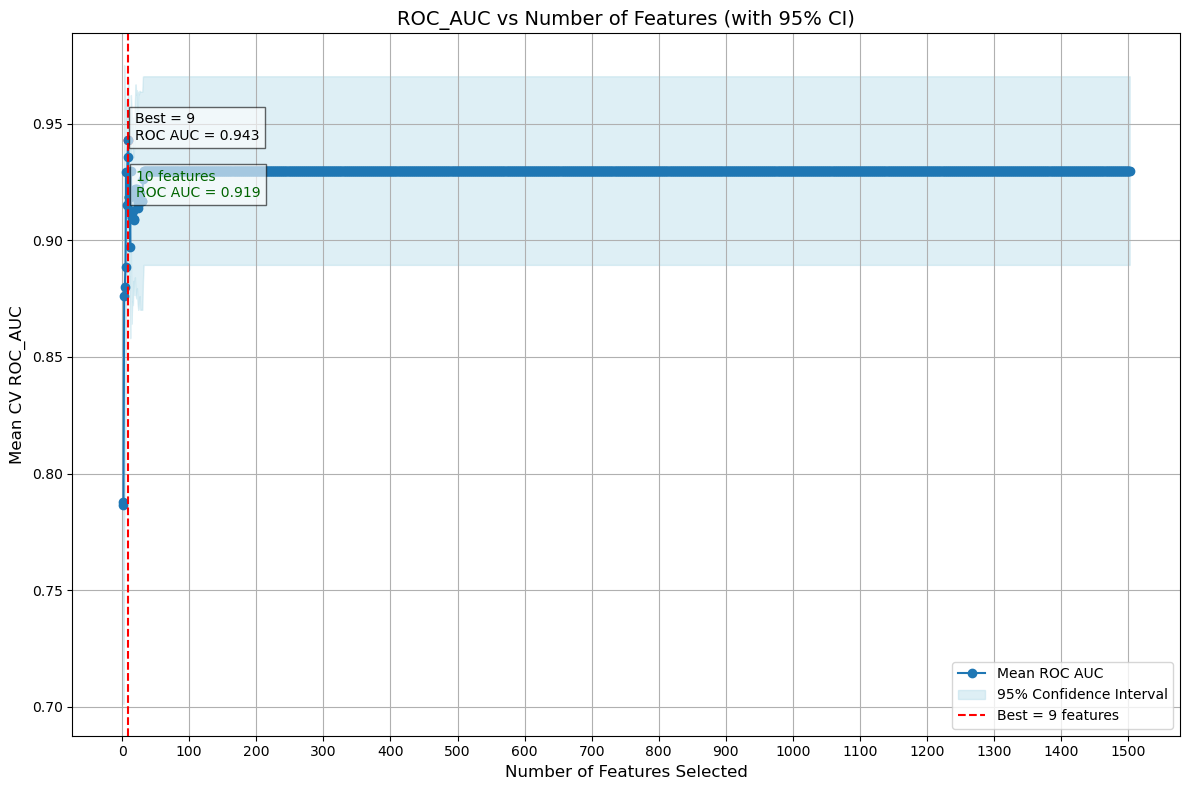

In [48]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initialize model

xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

cv_split = StratifiedKFold(5, shuffle=True, random_state=42)

xgb_rfecv = RFECV(
    estimator=xgboost_model,
    step=1,
    min_features_to_select=1,
    cv=cv_split,
    scoring="roc_auc",
    n_jobs=-1,
)

xgb_rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {xgb_rfecv.n_features_}")
print(f"Optimal features: {list(xgb_rfecv.get_feature_names_out())}")

xgb_rfecv.cv_results_

def plot_features_vs_cvscore_95ci(rfecv_model, cv_folds=5):
    n_features = len(rfecv_model.cv_results_["mean_test_score"])
    mean_scores = rfecv_model.cv_results_["mean_test_score"]
    std_scores = rfecv_model.cv_results_["std_test_score"]

    # Calculate 95% CI
    ci = 1.96 * (std_scores / np.sqrt(cv_folds))

    x_range = range(1, n_features + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(x_range, mean_scores, marker='o', label='Mean ROC AUC')
    plt.fill_between(x_range,
                 np.clip(mean_scores - ci, 0, 1),
                 np.clip(mean_scores + ci, 0, 1),
                 color='lightblue',
                 alpha=0.4,
                 label='95% Confidence Interval')


    # Annotate best feature point
    best_idx = np.argmax(mean_scores)
    best_score = mean_scores[best_idx]
    best_n_features = best_idx + 1
    plt.axvline(best_n_features, color='red', linestyle='--', label=f'Best = {best_n_features} features')
    plt.scatter(best_n_features, best_score, color='red')
    plt.text(best_n_features + 10, best_score,
             f'Best = {best_n_features}\nROC AUC = {best_score:.3f}',
             color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    # Annotate point at 10 features 
    if n_features >= 10:
        auc_at_10 = mean_scores[9]
        plt.scatter(10, auc_at_10, color='green')
        plt.text(10 + 10, auc_at_10,
                 f'10 features\nROC AUC = {auc_at_10:.3f}',
                 color='darkgreen', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    plt.xlabel("Number of Features Selected", fontsize=12)
    plt.ylabel("Mean CV ROC_AUC", fontsize=12)
    plt.title("ROC_AUC vs Number of Features (with 95% CI)", fontsize=14)
    plt.xticks(np.arange(0, n_features + 1, step=100))
    plt.grid(True)
    plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.show()
plot_features_vs_cvscore_95ci(xgb_rfecv, cv_folds=5)

4a. Xgboost model training using top features

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 9}

Confusion matrix:


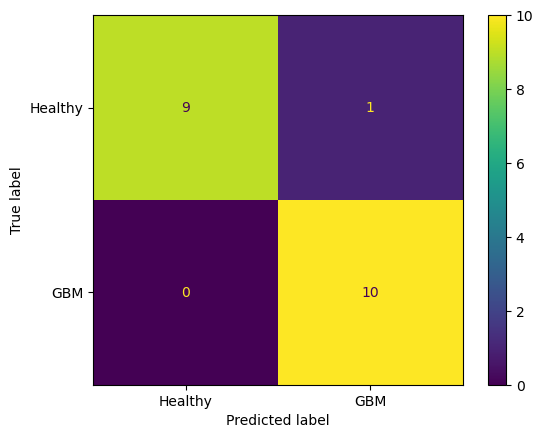

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20

CV AUC: 0.966 +/- 0.032


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

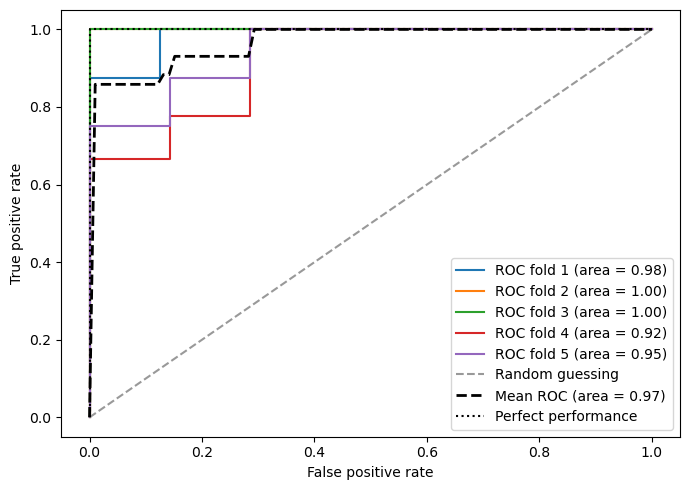

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

cv accuracy: 0.859 +/- 0.078
cv precision: 0.863 +/- 0.083
cv recall: 0.875 +/- 0.112
cv f1: 0.865 +/- 0.076


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import xgboost as xgb

# Initialize result lists
AUC = []
AUC_sd = []
AC = []
AC_sd = []
Pre = []
Pre_sd = []
Re = []
Re_sd = []
f1 = []
f1_sd = []
Best1 = []
Best2 = []


# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Perform Recursive Feature Elimination (RFE) to select top 10 features
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')


# Use only the selected features for training
XGB_train_selected = X_train[list(xgb_rfecv.get_feature_names_out())]
XGB_test_selected = X_test[list(xgb_rfecv.get_feature_names_out())]

# Perform GridSearchCV for hyperparameter tuning
param_range1 = [1, 3, 5, 7, 9]
gs = GridSearchCV(estimator=xgboost_model,
                  param_grid={'n_estimators': param_range1, 'max_depth': [1, 3, 5, 7, None], 'learning_rate': [0.01, 0.1, 0.2]},
                  scoring='accuracy', cv=2, refit=True, n_jobs=-1)
gs = gs.fit(XGB_train_selected, y_train)

# Get the best hyperparameters
best_params = gs.best_params_
print(f'Best Hyperparameters: {best_params}')

# Train the model with best hyperparameters
XGB_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss')
XGB_model.fit(XGB_train_selected, y_train)

# Test the model on the test set
test_pred = XGB_model.predict(XGB_test_selected)

# Confusion matrix
print("\nConfusion matrix:")
confusion_mat = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_mat, display_labels= ['Healthy', 'GBM'])
disp.plot()
plt.savefig("XGB_bestModel_ConfisionMatrix_FTIR_HG.png", format="png", dpi=600)
plt.savefig("XGB_bestModel_ConfisionMatrix_FTIR_HG.svg", format="svg", dpi=600)
plt.show()

# Classification report
print(classification_report(y_test, test_pred, target_names=[str(label) for label in np.unique(y)]))

# ROC/AUC Calculation for Cross-Validation
cv = list(StratifiedKFold(n_splits=5).split(XGB_train_selected, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

sd_list = []
for i, (train_idx, test_idx) in enumerate(cv):
    probas = XGB_model.fit(XGB_train_selected.iloc[train_idx], y_train.iloc[train_idx]).predict_proba(XGB_train_selected.iloc[test_idx])
    fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], probas[:, 1], pos_label=1)
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
    sd_list.append(roc_auc)

plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_sd = np.std(sd_list)

print(f'CV AUC: {mean_auc:.3f} +/- {mean_sd:.3f}')

# Plot mean ROC
plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("XGB_bestModel_AUC_FTIR_HG.png", format="png", dpi=600)
plt.savefig("XGB_bestModel_AUC_FTIR_HG.svg", format="svg", dpi=600)
plt.show()

AUC.append(mean_auc)
AUC_sd.append(mean_sd)

# Nested Cross-Validation with Multiple Metrics
scores1 = cross_val_score(gs, XGB_train_selected, y_train, scoring='accuracy', cv=5)
scores2 = cross_val_score(gs, XGB_train_selected, y_train, scoring='precision', cv=5)
scores3 = cross_val_score(gs, XGB_train_selected, y_train, scoring='recall', cv=5)
scores4 = cross_val_score(gs, XGB_train_selected, y_train, scoring='f1', cv=5)

print(f'cv accuracy: {np.mean(scores1):.3f} +/- {np.std(scores1):.3f}')
print(f'cv precision: {np.mean(scores2):.3f} +/- {np.std(scores2):.3f}')
print(f'cv recall: {np.mean(scores3):.3f} +/- {np.std(scores3):.3f}')
print(f'cv f1: {np.mean(scores4):.3f} +/- {np.std(scores4):.3f}')

AC.append(np.mean(scores1))
AC_sd.append(np.std(scores1))
Pre.append(np.mean(scores2))
Pre_sd.append(np.std(scores2))
Re.append(np.mean(scores3))
Re_sd.append(np.std(scores3))
f1.append(np.mean(scores4))
f1_sd.append(np.std(scores4))
Best1.append(gs.best_params_['n_estimators'])
Best2.append('NaN')


4b. XGB model for validation

In [51]:
# validation_data predictions 
validation_data_scaled = pd.DataFrame(scaler.transform(validation_data), columns=validation_data.columns, index=validation_data.index) # 
validation_data_selected = validation_data_scaled[list(xgb_rfecv.get_feature_names_out())]
validation_pred = XGB_model.predict(validation_data_selected)
print("Validation Data Predictions:")
for pid, pred in zip(validation_data_selected.index, validation_pred):
    print(f"{pid}: {'GBM' if pred == 1 else 'Healthy'}") 
# # save validation predictions to csv
validation_results = pd.DataFrame({'pid': validation_data_selected.index, 'Prediction': validation_pred})
validation_results['Prediction'] = validation_results['Prediction'].apply(lambda x: 'GBM' if x == 1 else 'Healthy')
validation_results.to_csv('XGB_FTIR_validation_predictions.csv', index=False)

Validation Data Predictions:
B1: GBM
C1: Healthy
D1: Healthy
E1: GBM
F1: Healthy


4a. Shaffiled class for best model -  Xgboost model training using top 10 features

In [ ]:
Ftir_data_train_shuffled1 = FTIR_data.copy()
# Select 23 samples from 0 and change them to 1
O_to_1_indices = Ftir_data_train_shuffled1[Ftir_data_train_shuffled1['target'] == 0].sample(n=24, random_state=1).index
print(O_to_1_indices)
# Select 23 samples from 1 and change them to 0
I_to_O_indices = Ftir_data_train_shuffled1[Ftir_data_train_shuffled1['target'] == 1].sample(n=24, random_state=1).index
print(I_to_O_indices)

Index(['H35', 'H25', 'H40', 'H38rpt', 'H03', 'H04', 'H33', 'H28', 'H46', 'H29',
       'H30', 'H49', 'H23', 'H36', 'H21', 'H42', 'H37', 'H26', 'H24', 'H15',
       'H41', 'H19', 'H48', 'H05'],
      dtype='object', name='pid')
Index(['027', '005', '111', '031', '040', '106', '035', '112', '039', '032',
       '006', '034', '109', '103', '101', '026', '102', '045', '024', '029',
       '018', '104', '022', '108'],
      dtype='object', name='pid')


In [62]:
Ftir_data_train_shuffled1.loc[O_to_1_indices, 'target'] = 1
Ftir_data_train_shuffled1.loc[I_to_O_indices, 'target'] = 0
print(Ftir_data_train_shuffled1['target'].value_counts())
print(Ftir_data_train_shuffled1[Ftir_data_train_shuffled1['target'] == 0].index)
print(Ftir_data_train_shuffled1[Ftir_data_train_shuffled1['target'] == 1].index)
# split data into train and test 80:20 ratio  
X = Ftir_data_train_shuffled1.drop(['target',], axis = 1)
y = Ftir_data_train_shuffled1['target']

target
1    51
0    48
Name: count, dtype: int64
Index(['005', '006', '018', '022', '024', '026', '027', '029', '031', '032',
       '034', '035', '039', '040', '045', '101', '102', '103', '104', '106',
       '108', '109', '111', '112', 'H01', 'H02', 'H06', 'H08', 'H09', 'H10',
       'H11', 'H12', 'H13', 'H14', 'H16', 'H17', 'H18', 'H20', 'H22', 'H27',
       'H31', 'H32', 'H34', 'H39', 'H43', 'H44', 'H45', 'H47'],
      dtype='object', name='pid')
Index(['003', '004', '008', '009', '010', '011', '013', '014', '015', '016',
       '017', '019', '020', '021', '023', '025', '028', '030', '033', '038',
       '041', '042', '043', '044', '105', '107', '110', 'H03', 'H04', 'H05',
       'H15', 'H19', 'H21', 'H23', 'H24', 'H25', 'H26', 'H28', 'H29', 'H30',
       'H33', 'H35', 'H36', 'H37', 'H38rpt', 'H40', 'H41', 'H42', 'H46', 'H48',
       'H49'],
      dtype='object', name='pid')


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 1}

Confusion matrix:


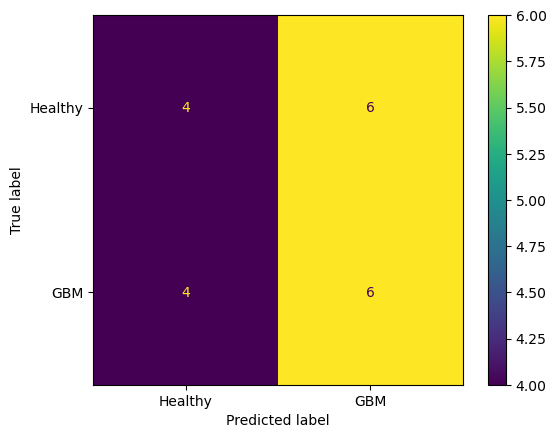

              precision    recall  f1-score   support

           0       0.50      0.40      0.44        10
           1       0.50      0.60      0.55        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.49        20
weighted avg       0.50      0.50      0.49        20



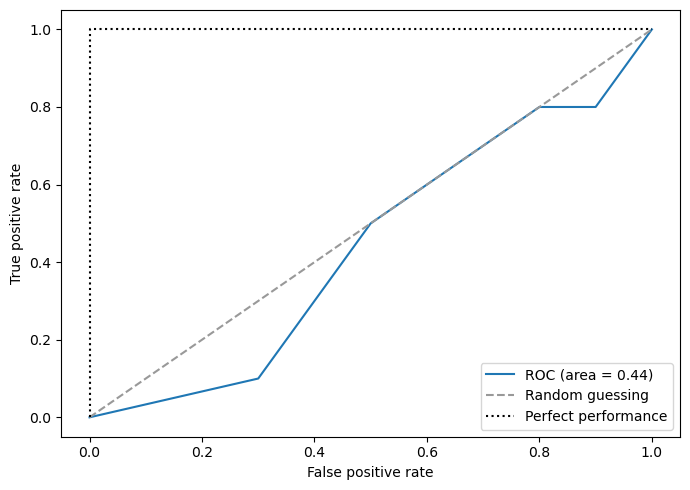

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

CV AUC: 0.706 +/- 0.093


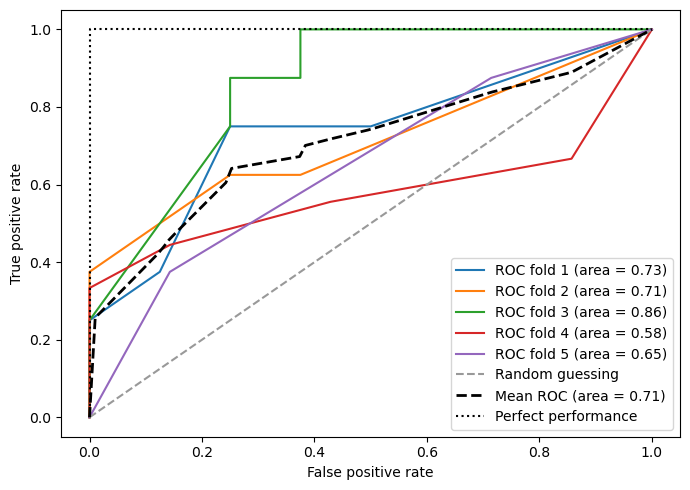

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

cv accuracy: 0.607 +/- 0.054
cv precision: 0.713 +/- 0.149
cv recall: 0.486 +/- 0.149
cv f1: 0.548 +/- 0.101


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import xgboost as xgb

# Initialize result lists
AUC = []
AUC_sd = []
AC = []
AC_sd = []
Pre = []
Pre_sd = []
Re = []
Re_sd = []
f1 = []
f1_sd = []
Best1 = []
Best2 = []


# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform Recursive Feature Elimination (RFE) to select top 10 features
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# Use only the selected features
X_train_selected, X_test_selected = X_train[list(xgb_rfecv.get_feature_names_out())[:10]], X_test[list(xgb_rfecv.get_feature_names_out())[:10]]

# Perform GridSearchCV for hyperparameter tuning
param_range1 = [1, 3, 5, 7, 9]
gs = GridSearchCV(estimator=xgboost_model,
                  param_grid={'n_estimators': param_range1, 'max_depth': [1, 3, 5, 7, None], 'learning_rate': [0.01, 0.1, 0.2]},
                  scoring='accuracy', cv=2, refit=True, n_jobs=-1)
gs = gs.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params = gs.best_params_
print(f'Best Hyperparameters: {best_params}')

# Train the model with best hyperparameters
best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss')
best_model.fit(X_train_selected, y_train)

# Test the model on the test set
test_pred = best_model.predict(X_test_selected)

# Confusion matrix
print("\nConfusion matrix:")
confusion_mat = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_mat, display_labels= ['Healthy', 'GBM'])
disp.plot()
plt.savefig("XGB_bestModel_shuffled_ConfusionMatrix_FTIR_HG.png", format="png", dpi=600)
plt.savefig("XGB_bestModel_shuffled_ConfusionMatrix_FTIR_HG.svg", format="svg", dpi=600)
plt.show()

# Classification report
print(classification_report(y_test, test_pred, target_names=[str(label) for label in np.unique(y)]))

# get AUC plot for the best model
fig = plt.figure(figsize=(7, 5))
probas = best_model.predict_proba(X_test_selected)
fpr, tpr, _ = roc_curve(y_test, probas[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("XGB_bestModel_shuffled_in_AUC_FTIR_HG.png", format="png", dpi=600)
plt.savefig("XGB_bestModel_shuffled_in_AUC_FTIR_HG.svg", format="svg", dpi=600)
plt.show()



# # ROC/AUC Calculation for Cross-Validation
# cv = list(StratifiedKFold(n_splits=5).split(X_train_selected, y_train))
# fig = plt.figure(figsize=(7, 5))
# mean_tpr = 0.0
# mean_fpr = np.linspace(0, 1, 100)
# all_tpr = []

# sd_list = []
# for i, (train_idx, test_idx) in enumerate(cv):
#     probas = best_model.fit(X_train_selected.iloc[train_idx], y_train.iloc[train_idx]).predict_proba(X_train_selected.iloc[test_idx])
#     fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], probas[:, 1], pos_label=1)
#     mean_tpr += np.interp(mean_fpr, fpr, tpr)
#     mean_tpr[0] = 0.0
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
#     sd_list.append(roc_auc)

# plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='Random guessing')

# mean_tpr /= len(cv)
# mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
# mean_sd = np.std(sd_list)

# print(f'CV AUC: {mean_auc:.3f} +/- {mean_sd:.3f}')

# # Plot mean ROC
# plt.plot(mean_fpr, mean_tpr, 'k--', label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
# plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')
# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.legend(loc="lower right")
# plt.tight_layout()
# plt.savefig("XGB_bestModel_shuffled_AUC_FTIR_HG.png", format="png", dpi=600)
# plt.savefig("XGB_bestModel_shuffled_AUC_FTIR_HG.svg", format="svg", dpi=600)
# plt.show()

# AUC.append(mean_auc)
# AUC_sd.append(mean_sd)

# # Nested Cross-Validation with Multiple Metrics
# scores1 = cross_val_score(gs, X_train_selected, y_train, scoring='accuracy', cv=5)
# scores2 = cross_val_score(gs, X_train_selected, y_train, scoring='precision', cv=5)
# scores3 = cross_val_score(gs, X_train_selected, y_train, scoring='recall', cv=5)
# scores4 = cross_val_score(gs, X_train_selected, y_train, scoring='f1', cv=5)

# print(f'cv accuracy: {np.mean(scores1):.3f} +/- {np.std(scores1):.3f}')
# print(f'cv precision: {np.mean(scores2):.3f} +/- {np.std(scores2):.3f}')
# print(f'cv recall: {np.mean(scores3):.3f} +/- {np.std(scores3):.3f}')
# print(f'cv f1: {np.mean(scores4):.3f} +/- {np.std(scores4):.3f}')

# AC.append(np.mean(scores1))
# AC_sd.append(np.std(scores1))
# Pre.append(np.mean(scores2))
# Pre_sd.append(np.std(scores2))
# Re.append(np.mean(scores3))
# Re_sd.append(np.std(scores3))
# f1.append(np.mean(scores4))
# f1_sd.append(np.std(scores4))
# Best1.append(gs.best_params_['n_estimators'])
# Best2.append('NaN')
